# DeepEyeNet-Image Captioning with key word reinforced
## Evaluation Part

In [13]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import json
import os
import re
import pickle
from tqdm import tqdm
from collections import defaultdict
import nltk
import h5py
import warnings
warnings.filterwarnings('ignore')
from nltk.translate.bleu_score import sentence_bleu

from keras.optimizers import Adam, RMSprop
from keras.models import load_model

from model import CaptionModel, KeywordModel

# Load Data

In [14]:
def load_json(file):
    with open(file,'r') as f:
        return json.load(f)
def save_json(data, file):
    with open(file,'w') as f:
        json.dump(data, f)
def load_pickle(file):
    with open(file,'rb') as f:
        return pickle.load(f)
def save_pickle(data, file):
    with open(file,'wb') as f:
        pickle.dump(data, f)

In [15]:
# train_imgs, val_imgs, test_imgs
train_imgs = load_pickle('./data/data_path/train_imgs.pkl')
val_imgs = load_pickle('./data/data_path/val_imgs.pkl')
test_imgs = load_pickle('./data/data_path/test_imgs.pkl')

# imgs features
train_imgs_features = load_pickle('./data/img_features/train_imgs_features_vgg_sub.pkl')
val_imgs_features = load_pickle('./data/img_features/val_imgs_features_vgg_sub.pkl')
test_imgs_features = load_pickle('./data/img_features/test_imgs_features_vgg_sub.pkl')

# Important features
results = load_pickle('./data/data_path/results.pkl')

In [16]:
# MODEL (No keywords)
# Parameters
vocab_size = len(results['word2id'])
max_len = max([len(x) for x in results['cap_toks'].values()])
embedding_size = 300

# load model
model_obj = CaptionModel(embedding_size, vocab_size, max_len, results['word2id'], results['id2word'])
final_model = model_obj.forward()
final_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
final_model = load_model('./model/model_vgg_new.h5')

In [17]:
# MODEL (with keywords)
# Parameters renewed
new_vocab_size = len(results['word2id_keys'])
key_max_len = max([len(x) for x in results['keywords_ids'].values()])

model_obj_k = KeywordModel(key_max_len, results['keywords_ids'], embedding_size, new_vocab_size,
                           vocab_size, max_len, results['word2id'], results['id2word'])
final_model_k = model_obj_k.forward()
final_model_k.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
final_model_k = load_model('./model/model_vgg_new_keywords.h5')

# Evaluation

## 1. Bleu Score

In [18]:
def evaluate_bleu(imgs, imgs_feats, model, obj, key_flag):
    
    avgscore = 0

    for i in tqdm(range(len(imgs))):
        if key_flag:
            predicted = obj.predict_captions_k(imgs[i], imgs_feats, model)
        else:
            predicted = obj.predict_captions(imgs[i], imgs_feats, model)
        ground_truth = results['descriptions'][imgs[i]]
        predicted_tok = obj.text_prepare(predicted)
        ground_truth_tok = [obj.text_prepare(ground_truth)]
        
        avgscore += sentence_bleu(ground_truth_tok, predicted_tok, weights=(1, 0, 0, 0))
    
    avgscore /= len(imgs)
    return avgscore

In [19]:
def evaluate_bleu_bs(imgs, imgs_feats, model, obj, key_flag):
    
    avgscore = 0

    for i in tqdm(range(len(imgs))):
        if key_flag:
            predicted = obj.predict_captions_beam_search_k(imgs[i], imgs_feats, model)
        else:
            predicted = obj.predict_captions_beam_search(imgs[i], imgs_feats, model)
        ground_truth = results['descriptions'][imgs[i]]
        predicted_tok = obj.text_prepare(predicted)
        ground_truth_tok = [obj.text_prepare(ground_truth)]
        
        avgscore += sentence_bleu(ground_truth_tok, predicted_tok, weights=(1, 0, 0, 0))
    
    avgscore /= len(imgs)
    return avgscore

## 2. METEOR

# --------------------------------------
# 1. Final model without keywords

Predicted Caption: 35 year old white female. srnv md. re 10/200 le 20/25.
Ground Truth Caption: 39-year-old white female. srnv-md. 20/20 and 10/200.
Bleu Score 1: 0.6153846153846154
Bleu Score 2: 0.4166666666666667
Bleu Score 3: 0.36363636363636365
Bleu Score 4: 0.3


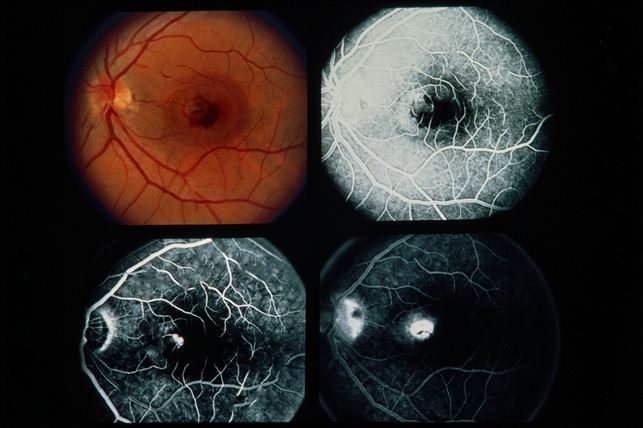

In [28]:
# final_model without keywords bleu score Example
train_id = 310
print('Predicted Caption: {}'.format(model_obj.predict_captions(train_imgs[train_id], train_imgs_features, final_model)))
print('Ground Truth Caption: {}'.format(results['descriptions'][train_imgs[train_id]]))

predicted = model_obj.predict_captions(train_imgs[train_id], train_imgs_features, final_model)
ground_truth = results['descriptions'][train_imgs[train_id]]
predicted_tok = model_obj.text_prepare(predicted)
ground_truth_tok = [model_obj.text_prepare(ground_truth)]

# Bleu Score Calculation
print('Bleu Score 1: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(1, 0, 0, 0))))
print('Bleu Score 2: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 1, 0, 0))))
print('Bleu Score 3: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 0, 1, 0))))
print('Bleu Score 4: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 0, 0, 1))))



Image.open(train_imgs[train_id]+'.jpg')

In [9]:
train_bleu = evaluate_bleu(train_imgs, train_imgs_features, final_model, model_obj, 0)
train_bleu

100%|██████████| 1567/1567 [17:09<00:00,  1.52it/s]


0.7354783252699579

In [10]:
test_bleu = evaluate_bleu(test_imgs, test_imgs_features, final_model, model_obj, 0)
test_bleu

100%|██████████| 196/196 [02:20<00:00,  1.40it/s]


0.6450051351681783

### Beam Search Score

In [32]:
# final_model without keywords bleu score Example
train_id = 332
print('Predicted Caption: {}'.format(model_obj.predict_captions_beam_search(train_imgs[train_id], train_imgs_features, final_model)))
print('Ground Truth Caption: {}'.format(results['descriptions'][train_imgs[train_id]]))

predicted = model_obj.predict_captions(train_imgs[train_id], train_imgs_features, final_model)
ground_truth = results['descriptions'][train_imgs[train_id]]
predicted_tok = model_obj.text_prepare(predicted)
ground_truth_tok = [model_obj.text_prepare(ground_truth)]
print('Bleu Score: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(1, 0, 0, 0))))

Predicted Caption: 77 year old black female. srnv md. 20/100 and 20/20.
Ground Truth Caption: 69-year-old black female. re 20/200 le 20/15. drusen.
Bleu Score: 0.5


# ---------------------------------------
# 2. Final model with keywords

Predicted Caption: 39 year old white female. srnv md. 20/20 and 10/200.
Ground Truth Caption: 39-year-old white female. srnv-md. 20/20 and 10/200.
Bleu Score 1: 1.0
Bleu Score 2: 1.0
Bleu Score 3: 1.0
Bleu Score 4: 1.0


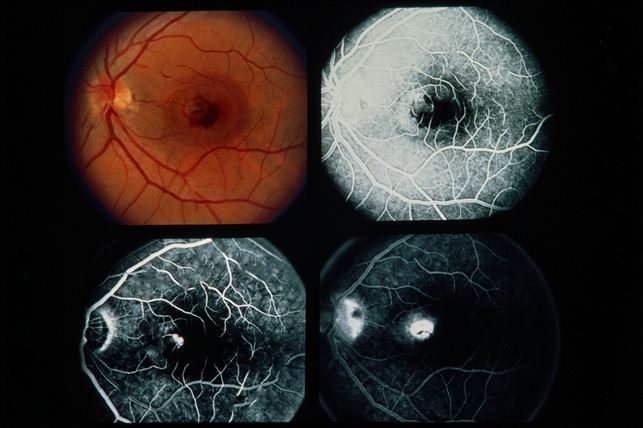

In [29]:
train_id = 310
print('Predicted Caption: {}'.format(model_obj_k.predict_captions_k(train_imgs[train_id], train_imgs_features, final_model_k)))
print('Ground Truth Caption: {}'.format(results['descriptions'][train_imgs[train_id]]))

predicted = model_obj_k.predict_captions_k(train_imgs[train_id], train_imgs_features, final_model_k)
ground_truth = results['descriptions'][train_imgs[train_id]]
predicted_tok = model_obj.text_prepare(predicted)
ground_truth_tok = [model_obj.text_prepare(ground_truth)]

# Bleu Score Calculation
print('Bleu Score 1: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(1, 0, 0, 0))))
print('Bleu Score 2: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 1, 0, 0))))
print('Bleu Score 3: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 0, 1, 0))))
print('Bleu Score 4: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(0, 0, 0, 1))))

Image.open(train_imgs[train_id]+'.jpg')

In [13]:
train_bleu_k = evaluate_bleu(train_imgs, train_imgs_features, final_model_k, model_obj_k, 1)

100%|██████████| 1567/1567 [15:35<00:00,  1.68it/s]


In [14]:
train_bleu_k

0.9283996395411378

In [15]:
test_bleu_k = evaluate_bleu(test_imgs, test_imgs_features, final_model_k, model_obj_k, 1)

100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


In [16]:
test_bleu_k

0.7225211741046165

### Beam Search Score

In [31]:
train_id = 332
print('Predicted Caption: {}'.format(model_obj_k.predict_captions_beam_search_k(train_imgs[train_id], train_imgs_features, final_model_k)))
print('Ground Truth Caption: {}'.format(results['descriptions'][train_imgs[train_id]]))

predicted = model_obj_k.predict_captions_k(train_imgs[train_id], train_imgs_features, final_model_k)
ground_truth = results['descriptions'][train_imgs[train_id]]
predicted_tok = model_obj.text_prepare(predicted)
ground_truth_tok = [model_obj.text_prepare(ground_truth)]
print('Bleu Score: {}'.format(sentence_bleu(ground_truth_tok, predicted_tok, weights=(1, 0, 0, 0))))

Predicted Caption: 69 year old black female. srnv md. 20/30 and 20/15.
Ground Truth Caption: 69-year-old black female. re 20/200 le 20/15. drusen.
Bleu Score: 0.6666666666666666


# Final Comparison

In [9]:
# Bleu Score Calculation
print("Average Bleu score for original model with train imgs:", train_bleu)
print("Average Bleu score for original model with test imgs:", test_bleu)
print("Average Bleu score for keyword model with train imgs:", train_bleu_k)
print("Average Bleu score for keyword model with test imgs:", test_bleu_k)

Average Bleu score for original model with train imgs: 0.7354783252699579
Average Bleu score for original model with test imgs: 0.6450051351681783
Average Bleu score for keyword model with train imgs: 0.9283996395411378
Average Bleu score for keyword model with test imgs: 0.7225211741046165
